# Imports

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the datasets

In [2]:
df = pd.read_csv('/Users/anilthapa/datasets/aircraft_price.csv')
df.shape

(517, 16)

In [3]:
df.head()

,model_name,engine_type,engine_power,max_speed,cruise_speed,stall_speed,fuel_tank,all_eng_roc,out_eng_roc,takeoff_distance,landing_distance,empty_weight,length,wing_span,range,price
0,100 Darter (S.L. Industries),Piston,145.0,104.0,91.0,46.0,36.0,450.0,900.0,1300.0,2050.0,1180.0,303.0,449.0,370.0,1300000.0
1,7 CCM Champ,Piston,85.0,89.0,83.0,44.0,15.0,600.0,720.0,800.0,1350.0,820.0,247.0,433.0,190.0,1230000.0
2,100 Darter (S.L. Industries),Piston,90.0,90.0,78.0,37.0,19.0,650.0,475.0,850.0,1300.0,810.0,257.0,420.0,210.0,1600000.0
3,7 AC Champ,Piston,85.0,88.0,78.0,37.0,19.0,620.0,500.0,850.0,1300.0,800.0,257.0,420.0,210.0,1300000.0
4,100 Darter (S.L. Industries),Piston,65.0,83.0,74.0,33.0,14.0,370.0,632.0,885.0,1220.0,740.0,257.0,420.0,175.0,1250000.0


# Data Analysis

## 1. Removing Null values

In [6]:
df.engine_type.value_counts()

engine_type
Piston     385
Jet         74
Propjet     58
Name: count, dtype: int64

In [9]:
df.dropna(inplace=True)

## 2. Dropping Unneccessary Columns

In [12]:
df.drop('model_name', axis = 1, inplace=True)

## 3. Describing the dataset

In [13]:
df.describe()

,engine_power,max_speed,cruise_speed,stall_speed,fuel_tank,all_eng_roc,out_eng_roc,takeoff_distance,landing_distance,empty_weight,length,wing_span,range,price
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,5.070000e+02
mean,863.637081,214.171598,199.761341,60.675542,1412.684418,1714.656805,2047.767258,1731.372781,7502.905325,4380.594675,387.364892,471.996055,911.315582,2.362673e+06
std,1790.042373,114.537893,102.549093,16.379207,4304.205584,1458.501440,1126.203775,708.224631,10345.250882,5677.649524,140.420370,102.476643,695.764134,1.018731e+06
min,60.000000,64.000000,70.000000,27.000000,12.000000,360.000000,457.000000,500.000000,850.000000,23.000000,211.000000,192.000000,117.000000,6.500000e+05
25%,200.000000,143.500000,131.000000,50.000000,50.000000,922.000000,1367.500000,1265.000000,2650.000000,1600.000000,302.000000,420.000000,520.000000,1.600000e+06
50%,285.000000,177.000000,169.000000,56.000000,90.000000,1200.000000,1706.000000,1525.000000,3650.000000,2286.500000,337.000000,438.000000,713.000000,2.000000e+06
75%,550.000000,239.000000,226.500000,72.000000,310.000000,1845.000000,2270.500000,2110.000000,8775.000000,5142.000000,426.000000,500.500000,1100.000000,2.950000e+06
max,14750.000000,755.000000,511.000000,115.000000,41000.000000,11673.000000,6400.000000,4850.000000,89400.000000,46800.000000,1157.000000,1122.000000,6500.000000,5.100000e+06


/Users/anilthapa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anilthapa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anilthapa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anilthapa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

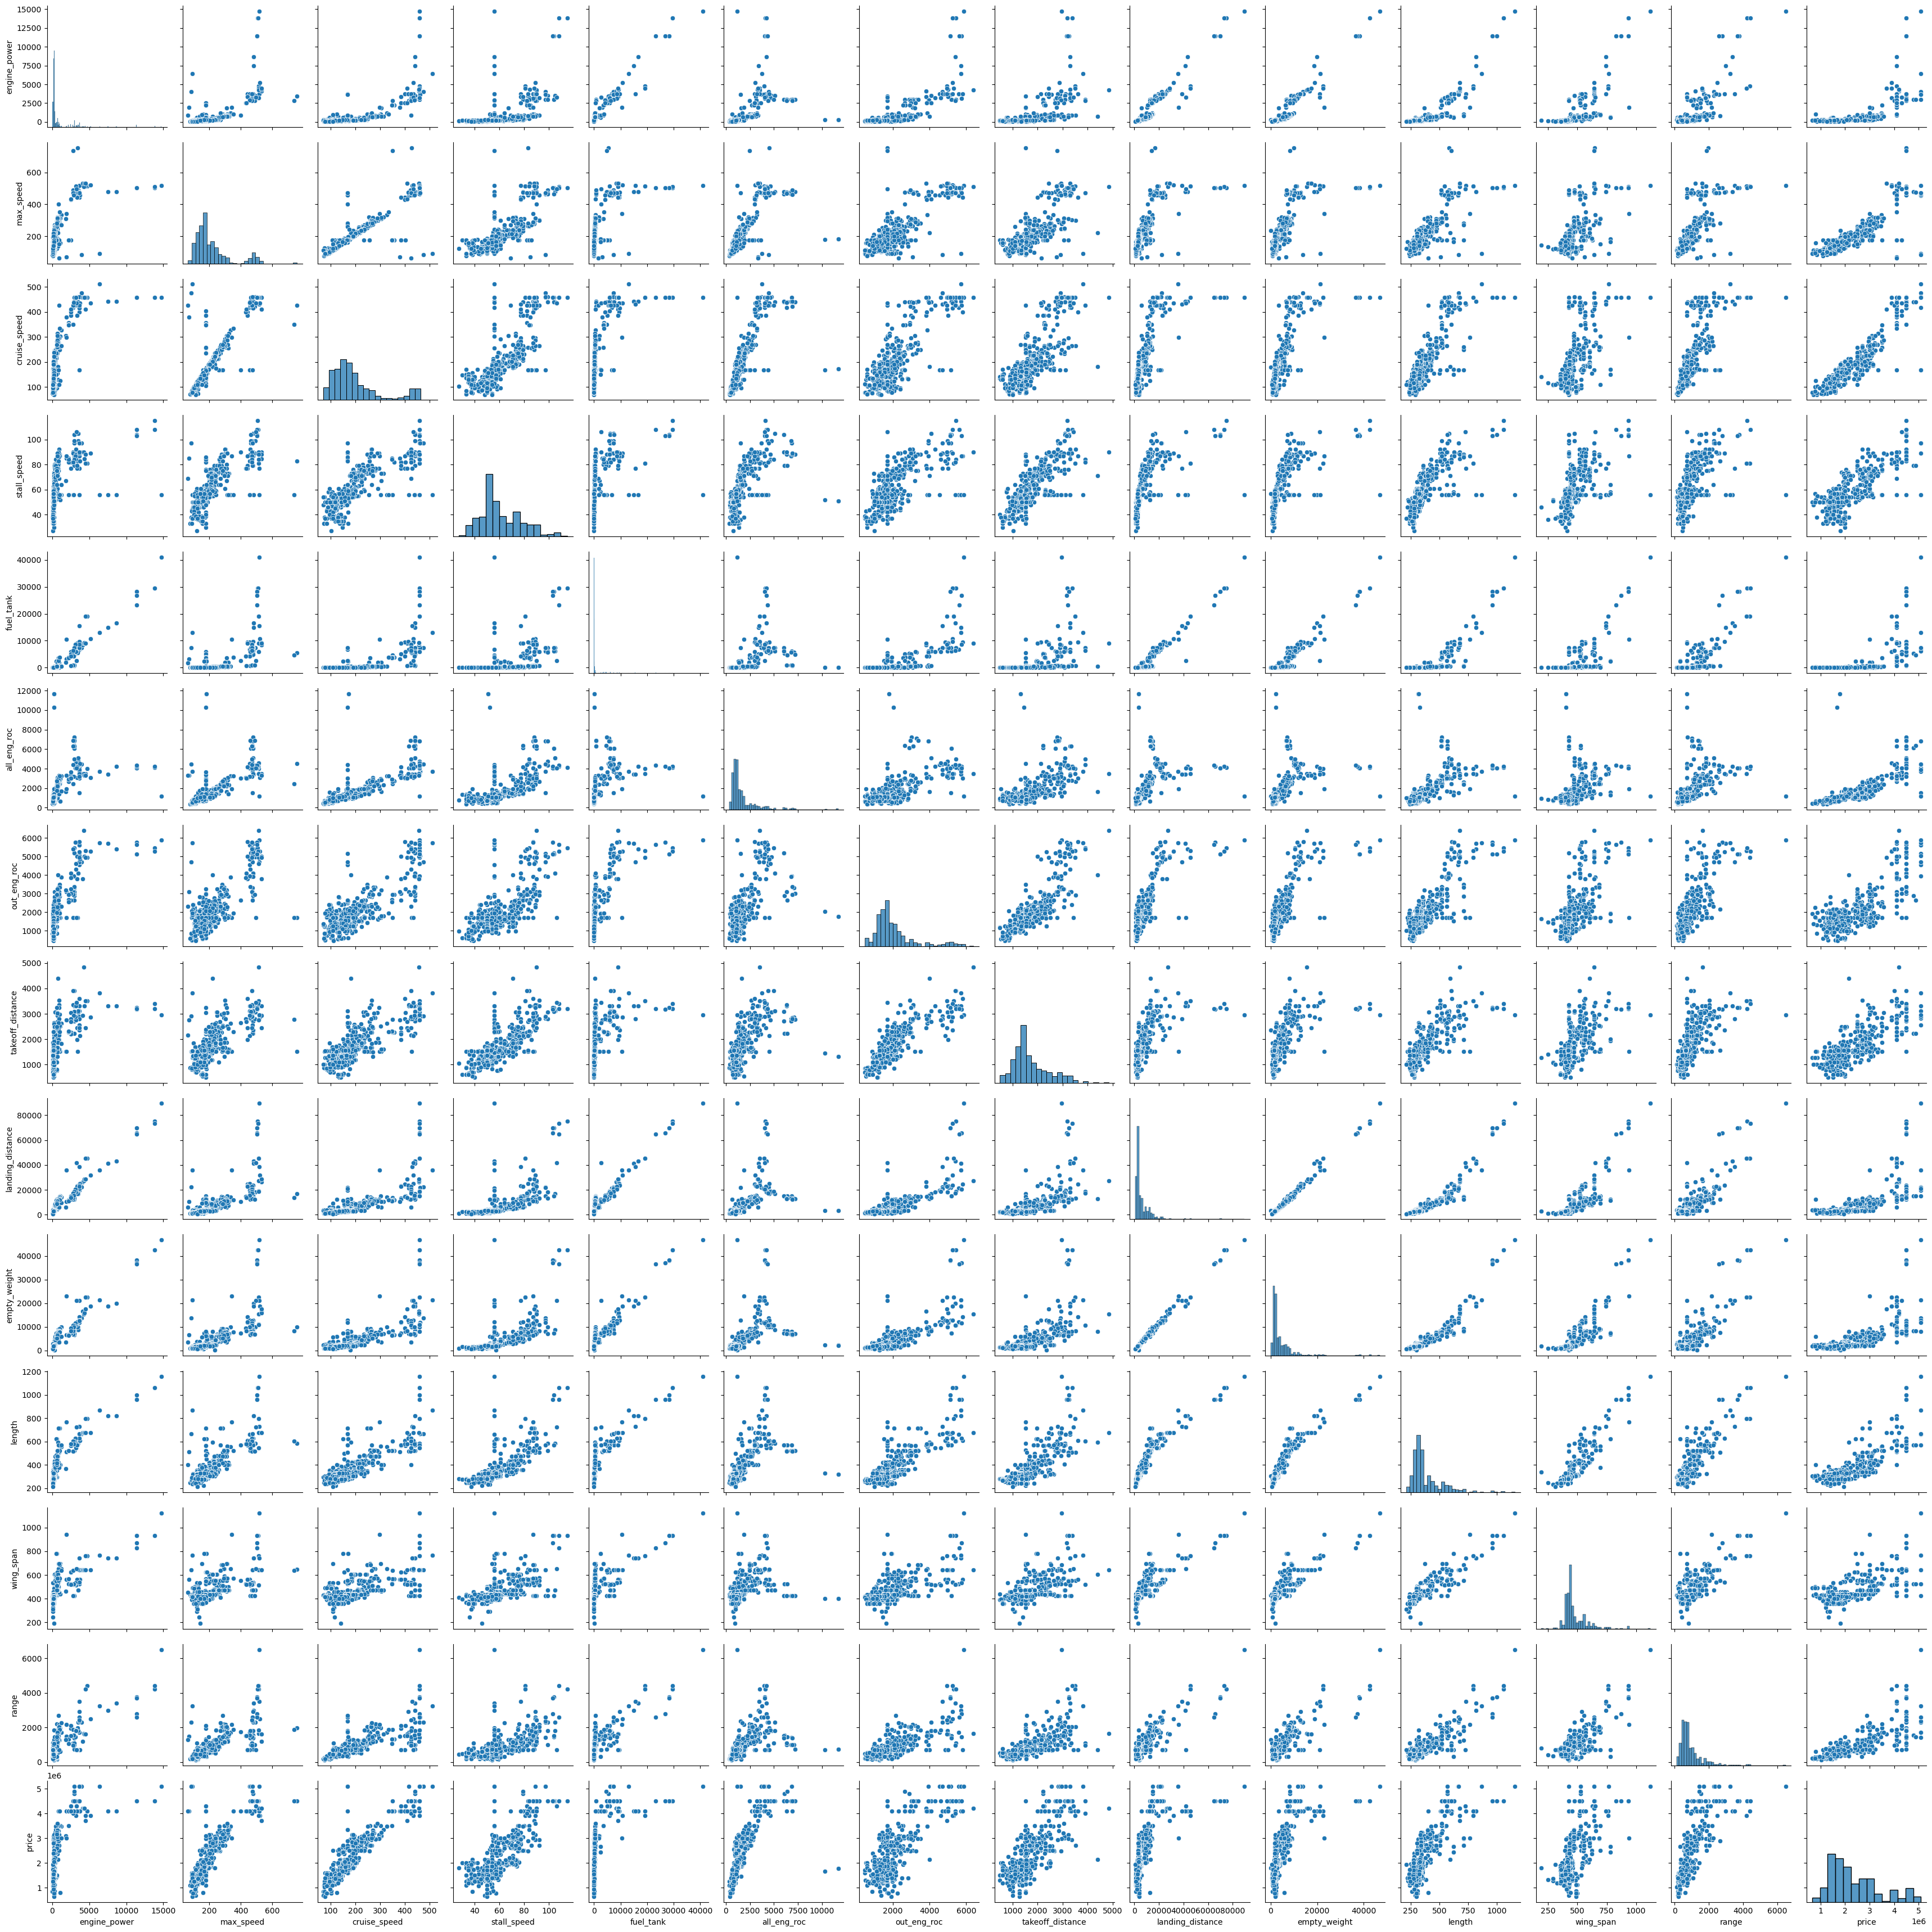

In [18]:
sns.pairplot(df.select_dtypes(include=['number']))

# Preproces the Dataset for training

In [53]:
X = df.drop('price', axis = 1)
y = df['price']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
num_columns = X.select_dtypes(include=['number']).columns
cats_columns = df.select_dtypes(exclude=['number']).columns

In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nums', StandardScaler(), num_columns),
        ('cats', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cats_columns)
    ]
)

In [57]:
preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

## Fit the dataset

In [58]:
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

In [61]:
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

# Train the model

In [74]:
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state = 42
)

In [75]:
xgb_reg.fit(X_train_preprocessed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Test the model

In [76]:
y_predict = xgb_reg.predict(X_test_preprocessed)

In [77]:
mean_squared_error(y_test, y_predict)

80172307542.47722

In [81]:
r2_score(y_test, y_predict)

0.9140624934301789

# Hyperparameter Tuning

In [82]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample':[0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

In [83]:
grid_search = GridSearchCV(xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=True, n_jobs=-1)

In [84]:
grid_search.fit(X_train_preprocessed, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.9],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error', verbose=True)

## Best Model

In [86]:
grid_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 300,
 'subsample': 0.8}

In [87]:
best_model = grid_search.best_estimator_

In [89]:
r2_score( y_test, best_model.predict(X_test_preprocessed))

0.9128092766393612